In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
folder = "/home/ovs2/lining/manual/AFQ10/"
starttime = 0
dt = 0.012

In [3]:
def read_out_tr(dir, file):
    col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
    df = pd.read_csv(dir+file, sep = ' ', header = None)
    df.columns = col
    return df

In [4]:
def get_receive_packets(df):
    df_out = df.loc[df["events"].isin(["r"])]
    df_out = df_out.loc[df_out["pkt_type"].isin(["tcp"])]
    df_out = df_out.loc[df_out["to_node"].isin([35])]
    return df_out

In [5]:
raw_data = read_out_tr(folder, "out.tr")
r_event_in_dst = get_receive_packets(raw_data)

In [6]:
r_event_in_dst.head()

,events,time,from_node,to_node,pkt_type,pkt_size,flags,fid,src_addr,dst_addr,seq_num,pkt_id
5171,r,1.005601,19,35,tcp,40,C--A---,7,23.0,35.3,0,1718
5224,r,1.005613,19,35,tcp,40,------N,7,23.0,35.3,1,1720
5225,r,1.005614,19,35,tcp,1500,------N,7,23.0,35.3,1,1721
5278,r,1.005627,19,35,tcp,1500,------N,7,23.0,35.3,1461,1723
5281,r,1.005627,19,35,tcp,1500,------N,7,23.0,35.3,2921,1724


In [7]:
r_event_in_dst['ts'] = r_event_in_dst['time'].apply(lambda x: pd.Timedelta(x,unit='s'))

In [8]:
grouped=r_event_in_dst.groupby('fid')

In [9]:
pkt_size_series = pd.Series(r_event_in_dst['pkt_size'], index=r_event_in_dst['ts'])

In [13]:
# H       hourly frequency
# T, min  minutely frequency
# S       secondly frequency
# L, ms   milliseonds
# U, us   microseconds
# N       nanoseconds
microseconds = 10
shortTh = grouped[['ts', 'pkt_size']].resample(str(microseconds) + 'U', on='ts').sum()
# GB
shortTh['throughtput'] = shortTh['pkt_size'] / (microseconds * 1e-6) / 1000 / 1000 / 1000
shortTh.head()

pkt_size  throughtput
fid ts                                    
7   00:00:01.005601        40     0.003725
    00:00:01.005611      1540     0.143424
    00:00:01.005621      3000     0.279397
    00:00:01.005631      4500     0.419095
    00:00:01.005641      1500     0.139698

In [11]:
res = shortTh[['throughtput']].unstack()['throughtput'].T
res.head()

fid,7
ts,
00:00:01.005601,0.003725
00:00:01.005611,0.143424
00:00:01.005621,0.279397
00:00:01.005631,0.419095
00:00:01.005641,0.139698


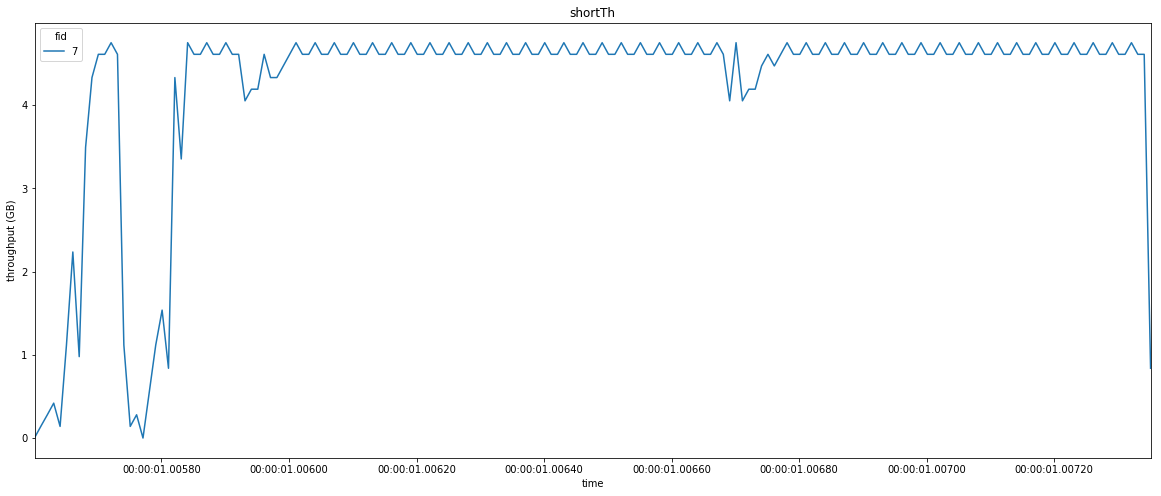

In [12]:
res.plot(kind='line', legend=True, title='shortTh', figsize=(20,8))
plt.xlabel('time')
plt.ylabel('throughput (GB)')
plt.show()